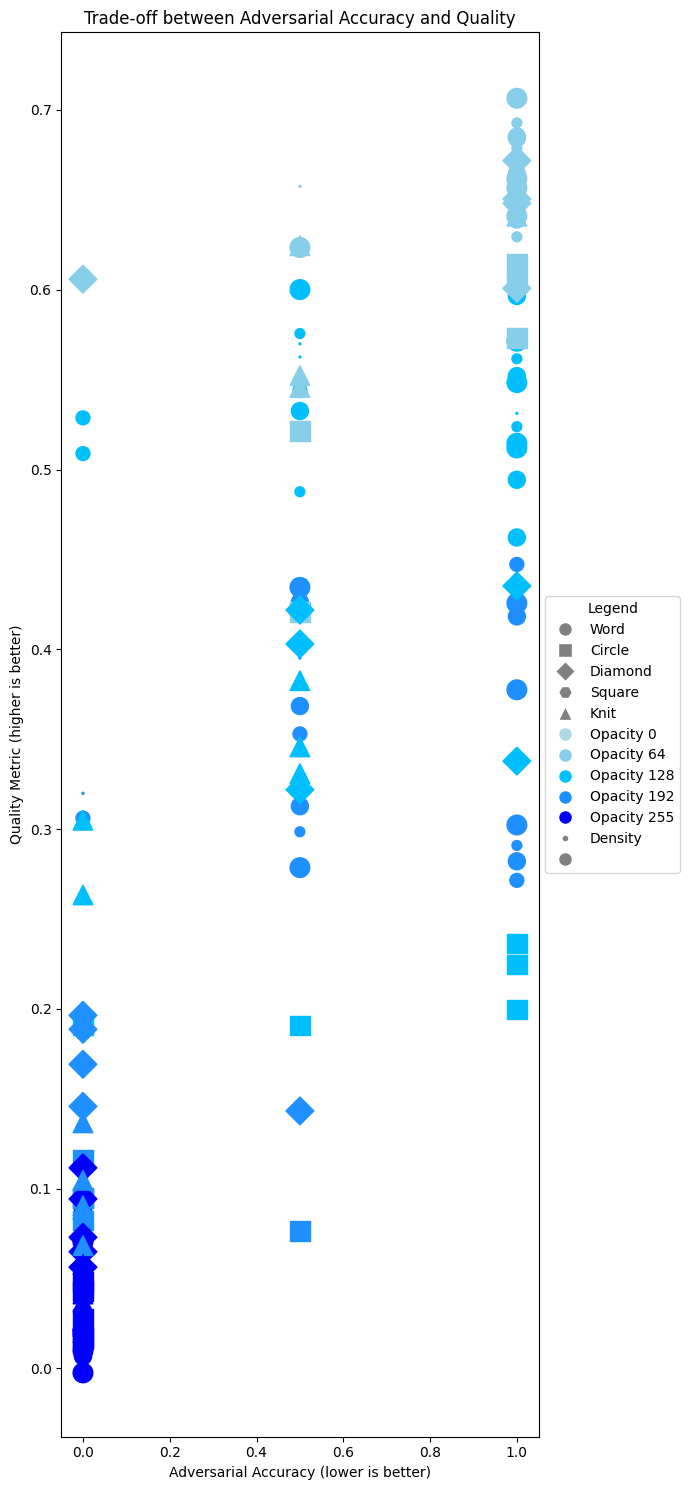

Top 10 results (lowest adversarial accuracy and highest quality):
       mask  opacity  density  adv_acc  x_acc   quality
1   diamond       64       75      0.0    1.0  0.605879
2    square       64       50      0.0    1.0  0.556541
3   diamond      255       75      0.0    1.0  0.111612
4    square      192        1      0.0    1.0  0.094773
5   diamond      255       75      0.0    1.0  0.094277
6    square      192        1      0.0    1.0  0.094072
7    square      192        1      0.0    1.0  0.083955
8   diamond      255       75      0.0    1.0  0.072972
9   diamond      255       75      0.0    1.0  0.064928
10  diamond      255       75      0.0    1.0  0.056351


In [2]:
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


datapath = Path.cwd().parent / "data" / "eval" / "0-eval_cls_mask.csv"
data = pd.read_csv(datapath)


# df = df.drop(columns=["img_id", "label"])
# df = df.drop(columns=["x_acc1", "x_acc5"])
# display(HTML(df.groupby(["mask"]).mean().reset_index().to_html()))
# display(HTML(df.groupby(["mask", "opacity"]).mean().reset_index().to_html()))
# display(HTML(df.groupby(["mask", "opacity", "density"]).mean().reset_index().to_html()))


data['adv_acc'] = (data['advx_acc1'] + data['advx_acc5']) / 2
data['quality'] = (data['cosine_sim'] + data['psnr'] / 100 + data['ssim']) / 3

markers = {'word': 'o', 'circle': 's', 'diamond': 'D', 'knit': '^'}

colors = {0: 'lightblue', 64: 'skyblue', 128: 'deepskyblue', 192: 'dodgerblue', 255: 'blue'}

plt.figure(figsize=(7, 15))

for mask in markers:
    for opacity in colors:
        mask_opacity_data = data[(data['mask'] == mask) & (data['opacity'] == opacity)]
        plt.scatter(mask_opacity_data['adv_acc'], mask_opacity_data['quality'], 
                    marker=markers[mask], c=colors[opacity], s=mask_opacity_data['density']*2,
                    label=f'{mask}, opacity={opacity}')

plt.xlabel('Adversarial Accuracy (lower is better)')
plt.ylabel('Quality Metric (higher is better)')
plt.title('Trade-off between Adversarial Accuracy and Quality')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Word', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w', label='Circle', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='D', color='w', label='Diamond', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='H', color='w', label='Square', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='^', color='w', label='Knit', markerfacecolor='gray', markersize=10)]

for opacity, color in colors.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Opacity {opacity}', markerfacecolor=color, markersize=10))

legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Density', markerfacecolor='gray', markersize=5))
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='', markerfacecolor='gray', markersize=10))

plt.legend(handles=legend_elements, title='Legend', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


data['x_acc'] = (data['x_acc1'] + data['x_acc5']) / 2
num_top = 10
top = data.nsmallest(num_top, 'adv_acc').nlargest(num_top, 'quality')
top = top.reset_index(drop=True)
top.index += 1  # start ranking from 1 instead of 0
print(f"Top {num_top} results (lowest adversarial accuracy and highest quality):")
print(top[['mask', 'opacity', 'density', 'adv_acc', 'x_acc', 'quality']])
